In [1]:
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearson3
from scipy.optimize import minimize

warnings.filterwarnings('ignore')

# Graphics setup
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)


def calculateMaxDD(cumret):
    """최대 낙폭 및 최대 낙폭 기간 계산"""
    cumret = np.asarray(cumret).flatten()
    highwatermark = np.zeros(cumret.shape)
    drawdown = np.zeros(cumret.shape)
    drawdownduration = np.zeros(cumret.shape)

    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t] = np.maximum(highwatermark[t - 1], cumret[t])
        drawdown[t] = (1 + cumret[t]) / (1 + highwatermark[t]) - 1
        if drawdown[t] == 0:
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t - 1] + 1

    maxDD = np.min(drawdown)
    i = np.argmin(drawdown)
    maxDDD = np.max(drawdownduration)
    return maxDD, maxDDD, i

# Chapter 8: Risk Management (리스크 관리) - 분석 리포트

> **데이터 출처**: Ernest Chan's "Algorithmic Trading" (2013)

---

## 목차

1. [개요 및 문제 정의](#1-개요-및-문제-정의)
2. [사용 데이터](#2-사용-데이터)
3. [켈리 공식 (가우시안 가정)](#3-분석-1-켈리-공식-가우시안-가정)
4. [몬테카를로 최적 레버리지](#4-분석-2-몬테카를로-최적-레버리지)
5. [다양한 레버리지에서의 최대 낙폭](#5-분석-3-다양한-레버리지에서의-최대-낙폭)
6. [CPPI](#6-분석-4-cppi)
7. [레버리지 민감도 분석](#7-분석-5-레버리지-민감도-분석)
8. [결론 및 권고사항](#8-결론-및-권고사항)

---

## 1. 개요 및 문제 정의

### 핵심 질문

- 전략의 장기 복리 성장률을 극대화하는 **최적 레버리지**는 얼마인가?
- 과도한 레버리지로 인한 **파산 위험**을 어떻게 관리하는가?
- **최대 낙폭(Maximum Drawdown)** 제약 하에서 성장률을 어떻게 최적화하는가?
- **CPPI**는 낙폭 제한과 성장률 극대화를 동시에 달성할 수 있는가?

### 핵심 수식

**켈리 공식 (가우시안 가정):**
$$f^* = \frac{m}{s^2}$$
- $m$: 평균 초과 수익률, $s^2$: 초과 수익률의 분산

**복리 성장률 (일반):**
$$g(f) = \langle \log(1 + f \cdot R) \rangle$$
- $f$: 레버리지, $R$: 전략의 비레버리지 바당 수익률

**CPPI 성장률:**
$$g_{CPPI} = \frac{1}{T} \sum_{t=1}^{T} \log(1 + R_t \cdot D \cdot f^* \cdot (1 + d_t))$$
- $D$: 허용 최대 낙폭, $d_t$: 현재 낙폭 (항상 $\leq 0$)

---

## 2. 사용 데이터

| 파일명 | 내용 | 데이터 수 | 용도 |
|--------|------|-----------|------|
| `AUDCAD_unequal_ret.csv` | AUD/CAD 페어 트레이딩 일일 수익률 | 612개 | 레버리지 최적화 입력 |
| `calculateMaxDD.py` | 최대 낙폭 계산 유틸리티 | - | 낙폭 분석 |

이 데이터는 Chapter 5 예제 5.1의 AUD/USD vs CAD/USD 요한센 공적분 페어 트레이딩 전략에서 생성된 일일 수익률이다.

---

In [2]:
# 데이터 로드
print("=" * 60)
print("📂 데이터 로드")
print("=" * 60)

ret_df = pd.read_csv("AUDCAD_unequal_ret.csv")
ret = ret_df['Return'].values

print(f"  ✓ AUD/CAD 전략 수익률: {len(ret)} 거래일")
print(f"    평균 일일 수익률: {np.mean(ret):.6f}")
print(f"    일일 수익률 표준편차: {np.std(ret, ddof=1):.6f}")

📂 데이터 로드
  ✓ AUD/CAD 전략 수익률: 612 거래일
    평균 일일 수익률: 0.000432
    일일 수익률 표준편차: 0.004256


---

## 3. 분석 1: 켈리 공식 (가우시안 가정)

### 방법론

수익률이 정규분포를 따른다고 가정하면, 복리 성장률을 최대화하는 최적 레버리지는 $f^* = m/s^2$로 주어진다.
하프-켈리($f^*/2$)는 추정 오류에 대한 안전 마진을 제공한다.

In [3]:
# 분석 1: 켈리 공식
print("=" * 60)
print("📈 분석 1: 켈리 공식 (가우시안 가정)")
print("=" * 60)

m = np.mean(ret)
s2 = np.var(ret, ddof=1)
s = np.std(ret, ddof=1)

kelly_f = m / s2

# 켈리 성장률: g = f*m - f^2*s^2/2
kelly_g = kelly_f * m - kelly_f**2 * s2 / 2

# 하프-켈리
half_kelly_f = kelly_f / 2
half_kelly_g = half_kelly_f * m - half_kelly_f**2 * s2 / 2

print(f"  [수익률 통계]")
print(f"    평균 일일 수익률 (m) = {m:.6f}")
print(f"    표준편차 (s) = {s:.6f}")
print(f"    분산 (s^2) = {s2:.8f}")
print()
print(f"  [켈리 공식: f = m / s^2]")
print(f"    최적 레버리지 (f) = {kelly_f:.2f}")
print(f"    최적 성장률 (g) = {kelly_g:.6f}")
print()
print(f"  [하프-켈리]")
print(f"    레버리지 (f/2) = {half_kelly_f:.2f}")
print(f"    성장률 = {half_kelly_g:.6f}")

📈 분석 1: 켈리 공식 (가우시안 가정)
  [수익률 통계]
    평균 일일 수익률 (m) = 0.000432
    표준편차 (s) = 0.004256
    분산 (s^2) = 0.00001811

  [켈리 공식: f = m / s^2]
    최적 레버리지 (f) = 23.85
    최적 성장률 (g) = 0.005149

  [하프-켈리]
    레버리지 (f/2) = 11.92
    성장률 = 0.003862


### 결과

| 지표 | 값 |
|------|-----|
| 평균 일일 수익률 (m) | 0.000432 |
| 표준편차 (s) | 0.004256 |
| 분산 (s^2) | 0.00001811 |
| 켈리 최적 레버리지 (f*) | 23.85 |
| 켈리 최적 성장률 | 0.005149 |
| 하프-켈리 레버리지 | 11.92 |
| 하프-켈리 성장률 | 0.003862 |

---

## 4. 분석 2: 몬테카를로 최적 레버리지

### 방법론

1. 역사적 수익률에 피어슨 Type III 분포를 피팅
2. 100,000개의 무작위 수익률을 시뮬레이션
3. $g(f) = \langle \log(1 + fR) \rangle$를 수치 최적화하여 최적 레버리지 탐색
4. 비가우시안 팻 테일을 고려한 보다 현실적인 레버리지 결정

In [4]:
# 분석 2: 몬테카를로 최적 레버리지
print("=" * 60)
print("📈 분석 2: 몬테카를로 최적 레버리지 (피어슨 Type III)")
print("=" * 60)

# 피어슨 Type III 분포 피팅
skew_, loc_, scale_ = pearson3.fit(ret_df)  # DataFrame 전달 (원본과 동일)
mean_dist, var_dist, skew_dist, kurt_dist = pearson3.stats(skew_, loc_, scale_, moments='mvks')

print(f"  [피어슨 Type III 피팅]")
print(f"    skew={skew_:.6f}, loc={loc_:.6f}, scale={scale_:.6f}")
print(f"    분포 모멘트: mean={mean_dist:.6f}, var={var_dist:.8f}, skew={skew_dist:.4f}, kurt={kurt_dist:.4f}")
print()

# 시뮬레이션된 수익률 생성 (random_state=0 고정)
ret_sim = pearson3.rvs(skew_, loc_, scale_, size=100000, random_state=0)

# 복리 성장률 함수
def g(f, R):
    return np.sum(np.log(1 + f * R), axis=0) / R.shape[0]

# f=1~23에서 g(f) 계산
myf = range(1, 24)
myg = np.full(24, np.nan)
for f in myf:
    myg[f] = g(f, ret_sim)
myg_plot = myg[1:]

# 최적화 - 시뮬레이션 수익률 기반
minusGsim = lambda f: -g(f, ret_sim)
res_sim = minimize(minusGsim, 0, method='Nelder-Mead')
optimalF_sim = float(res_sim.x[0])
optimalG_sim = float(-res_sim.fun)

# 최적화 - 역사적 수익률 기반
minusG = lambda f: -g(f, ret)
res_hist = minimize(minusG, 0, method='Nelder-Mead')
optimalF_hist = float(res_hist.x[0])
optimalG_hist = float(-res_hist.fun)

# 최소 수익률 (파산 레버리지 한계)
minR = np.min(ret_sim)
bankruptcy_f = 1.0 / abs(minR)

print(f"  [시뮬레이션 수익률 기반 최적화]")
print(f"    Optimal leverage = {optimalF_sim:.4f}")
print(f"    Optimal growth rate = {optimalG_sim:.6f}")
print(f"    책 기대값: leverage=25.51, growth rate=0.005767")
print()
print(f"  [역사적 수익률 기반 최적화]")
print(f"    Optimal leverage = {optimalF_hist:.4f}")
print(f"    Optimal growth rate = {optimalG_hist:.6f}")
print()
print(f"  [파산 한계]")
print(f"    최소 시뮬레이션 수익률 = {minR:.6f}")
print(f"    파산 레버리지 = 1/|minR| = {bankruptcy_f:.2f}")

📈 분석 2: 몬테카를로 최적 레버리지 (피어슨 Type III)
  [피어슨 Type III 피팅]
    skew=0.122820, loc=0.000432, scale=0.004231
    분포 모멘트: mean=0.000432, var=0.00001790, skew=0.1228, kurt=0.0226

  [시뮬레이션 수익률 기반 최적화]
    Optimal leverage = 25.5126
    Optimal growth rate = 0.005767
    책 기대값: leverage=25.51, growth rate=0.005767

  [역사적 수익률 기반 최적화]
    Optimal leverage = 23.7218
    Optimal growth rate = 0.005198

  [파산 한계]
    최소 시뮬레이션 수익률 = -0.018201
    파산 레버리지 = 1/|minR| = 54.94


### 피어슨 Type III 분포 파라미터

| 파라미터 | 값 |
|----------|-----|
| skew | 0.122820 |
| loc | 0.000432 |
| scale | 0.004231 |
| 분포 mean | 0.000432 |
| 분포 variance | 0.00001790 |
| 분포 skewness | 0.1228 |
| 분포 kurtosis | 0.0226 |

### 최적화 결과

| 방법 | 최적 레버리지 | 최적 성장률 | 책 기대값 |
|------|-------------|-----------|----------|
| 시뮬레이션 수익률 | 25.5126 | 0.005767 | f=25.51, g=0.005767 |
| 역사적 수익률 | 23.7218 | 0.005198 | f=18.4 (켈리와 동일) |

파산 한계: 최소 시뮬레이션 수익률 = -0.018201, 파산 레버리지 = 54.94

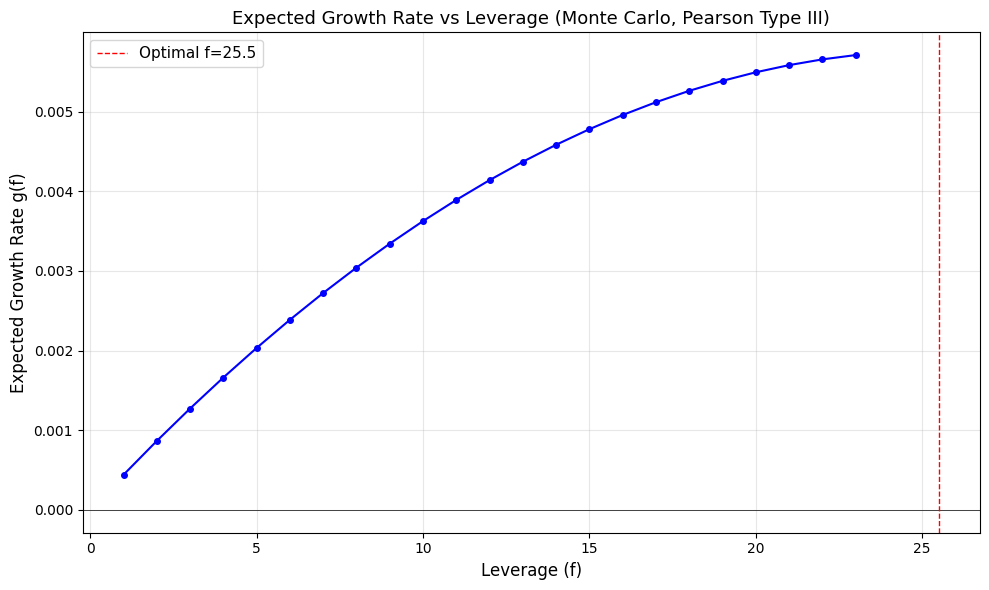

In [5]:
# 차트: g(f) 곡선 (그림 8.2 재현)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(list(myf), myg_plot, 'b-o', markersize=4, linewidth=1.5)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=optimalF_sim, color='r', linewidth=1, linestyle='--',
           label=f'Optimal f={optimalF_sim:.1f}')
ax.set_xlabel('Leverage (f)', fontsize=12)
ax.set_ylabel('Expected Growth Rate g(f)', fontsize=12)
ax.set_title('Expected Growth Rate vs Leverage (Monte Carlo, Pearson Type III)', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 5. 분석 3: 다양한 레버리지에서의 최대 낙폭

### 방법론

최적 레버리지의 다양한 비율에서 시뮬레이션/역사적 수익률로 최대 낙폭을 계산.
낙폭을 허용 수준 이하로 줄이려면 켈리의 1/7 수준으로 레버리지를 낮춰야 한다.

In [6]:
# 분석 3: 다양한 레버리지에서의 최대 낙폭
print("=" * 60)
print("📈 분석 3: 다양한 레버리지에서의 최대 낙폭")
print("=" * 60)

optimalF = optimalF_sim

leverage_tests = [
    ('Full (f)', 1.0, ret_sim, 'simulated'),
    ('Half (f/2)', 0.5, ret_sim, 'simulated'),
    ('1/7 (f/7)', 1.0 / 7, ret_sim, 'simulated'),
    ('1/1.4 (f/1.4, hist)', 1.0 / 1.4, ret, 'historical'),
]

dd_results = []
for label, frac, ret_data, source in leverage_tests:
    lev = optimalF * frac
    cumret = np.cumprod(1 + lev * ret_data) - 1
    maxDD, maxDDD, dd_idx = calculateMaxDD(cumret)
    dd_results.append({
        'label': label, 'frac': frac, 'leverage': lev,
        'maxDD': maxDD, 'maxDDD': maxDDD, 'source': source,
    })
    print(f"  {label}: leverage={lev:.4f}, MaxDD={maxDD:.6f}")

print()
print(f"  [책 기대값]")
print(f"    Full leverage: MaxDD=-0.996312")
print(f"    Half leverage: MaxDD=-0.900276")
print(f"    1/7 leverage:  MaxDD=-0.429629")
print(f"    1/1.4 (hist):  MaxDD=-0.625894")

📈 분석 3: 다양한 레버리지에서의 최대 낙폭
  Full (f): leverage=25.5126, MaxDD=-0.996312
  Half (f/2): leverage=12.7563, MaxDD=-0.900276
  1/7 (f/7): leverage=3.6447, MaxDD=-0.429629
  1/1.4 (f/1.4, hist): leverage=18.2233, MaxDD=-0.625894

  [책 기대값]
    Full leverage: MaxDD=-0.996312
    Half leverage: MaxDD=-0.900276
    1/7 leverage:  MaxDD=-0.429629
    1/1.4 (hist):  MaxDD=-0.625894


### 결과

| 레버리지 비율 | 실제 레버리지 | MaxDD | 수익률 소스 | 책 기대값 |
|-------------|------------|-------|-----------|----------|
| Full (f) | 25.5126 | -0.996312 | simulated | -0.996312 |
| Half (f/2) | 12.7563 | -0.900276 | simulated | -0.900276 |
| 1/7 (f/7) | 3.6447 | -0.429629 | simulated | -0.429629 |
| 1/1.4 (f/1.4, hist) | 18.2233 | -0.625894 | historical | -0.625894 |

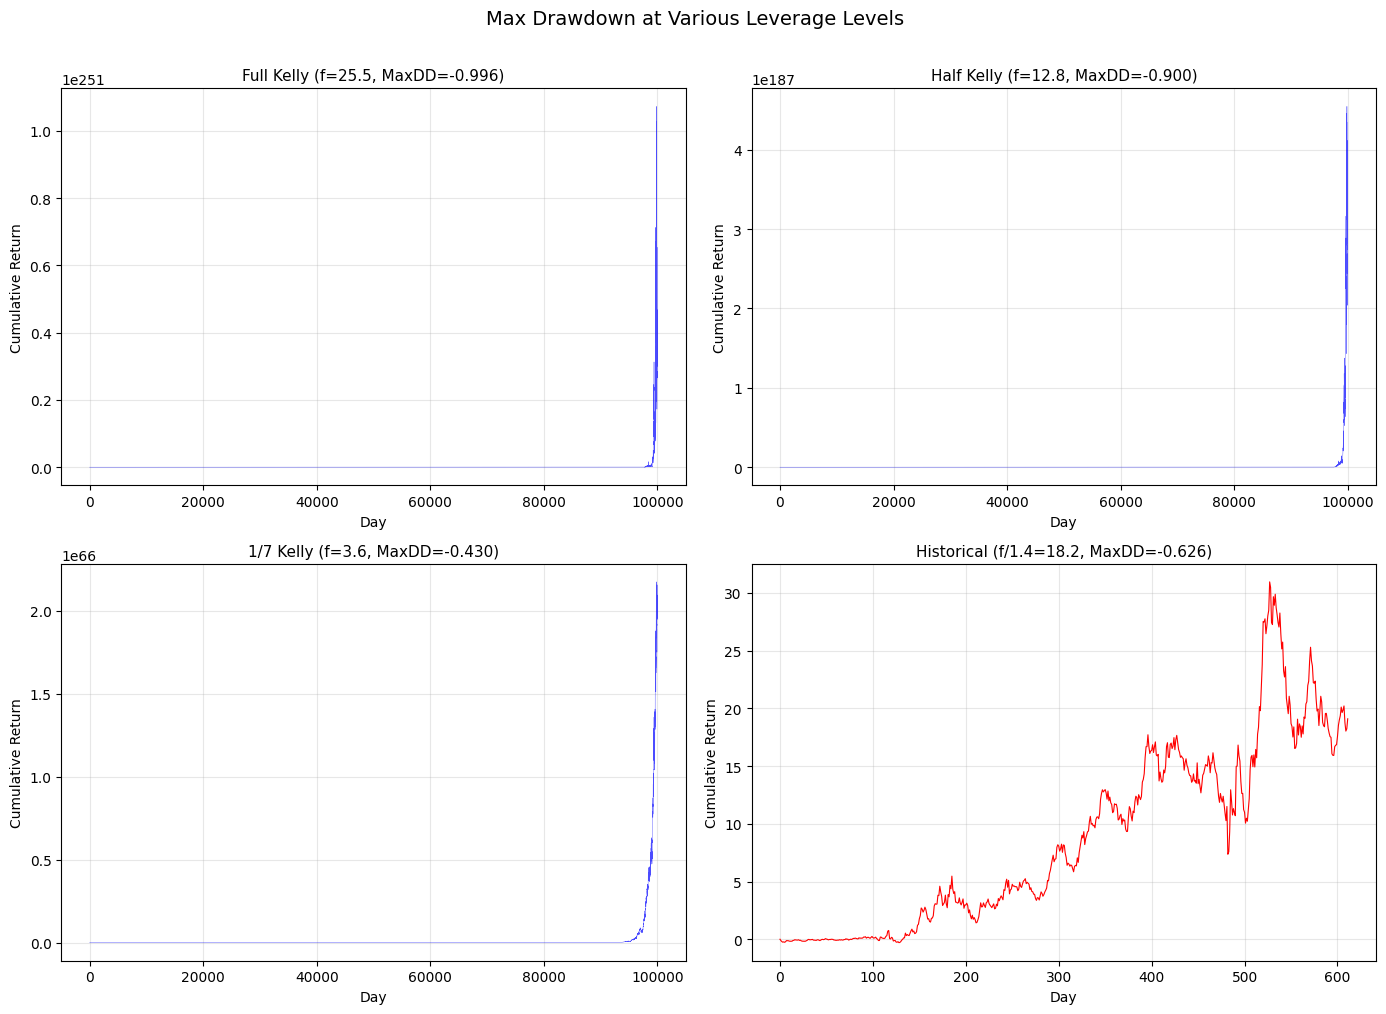

In [7]:
# 차트: 레버리지 비율별 누적 수익률
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sim_fracs = [1.0, 0.5, 1.0 / 7]
sim_labels = ['Full Kelly', 'Half Kelly', '1/7 Kelly']
for idx, (frac, label) in enumerate(zip(sim_fracs, sim_labels)):
    ax = axes[idx // 2][idx % 2]
    lev = optimalF * frac
    cumret = np.cumprod(1 + lev * ret_sim) - 1
    maxDD = dd_results[idx]['maxDD']
    ax.plot(cumret, 'b-', linewidth=0.3, alpha=0.7)
    ax.set_title(f'{label} (f={lev:.1f}, MaxDD={maxDD:.3f})', fontsize=11)
    ax.set_ylabel('Cumulative Return')
    ax.set_xlabel('Day')
    ax.grid(True, alpha=0.3)

# 역사적 수익률 (f/1.4)
ax = axes[1][1]
lev = optimalF / 1.4
cumret = np.cumprod(1 + lev * ret) - 1
maxDD = dd_results[3]['maxDD']
ax.plot(cumret, 'r-', linewidth=0.8)
ax.set_title(f'Historical (f/1.4={lev:.1f}, MaxDD={maxDD:.3f})', fontsize=11)
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Day')
ax.grid(True, alpha=0.3)

plt.suptitle('Max Drawdown at Various Leverage Levels', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

---

## 6. 분석 4: CPPI (Constant Proportion Portfolio Insurance)

### 방법론

1. 총 계좌 자본의 D만큼을 거래용 하위 계좌에 배분
2. 하위 계좌에 최적 켈리 레버리지 적용
3. 낙폭 발생 시 자동으로 주문 규모 축소: $f_{effective} = f^* \cdot D \cdot (1 + d_t)$
4. 총 계좌의 최대 낙폭이 $-D$를 초과하지 않도록 보장

CPPI의 핵심 장점: 단순히 $f \cdot D$ 레버리지를 사용하는 것과 유사한 성장률을 제공하면서,
최대 낙폭을 D 이내로 **보장**한다.

In [8]:
# 분석 4: CPPI
print("=" * 60)
print("📈 분석 4: CPPI (Constant Proportion Portfolio Insurance)")
print("=" * 60)

D = 0.5

def g_func(f, R):
    return np.sum(np.log(1 + f * R), axis=0) / R.shape[0]

# === 시뮬레이션 수익률 - 단순 D*f 레버리지 ===
g_simple_sim = g_func(optimalF * D, ret_sim)
maxDD_simple_sim, _, _ = calculateMaxDD(np.cumprod(1 + optimalF * D * ret_sim) - 1)

print(f"  [D={D} 단순 레버리지 (시뮬레이션)]")
print(f"    Growth rate = {g_simple_sim:.6f}")
print(f"    MaxDD = {maxDD_simple_sim:.6f}")
print()

# === 시뮬레이션 수익률 - CPPI ===
g_cppi_sim = 0.0
drawdown = 0.0
cppi_equity_sim = np.zeros(len(ret_sim))
for t in range(len(ret_sim)):
    g_cppi_sim += np.log(1 + ret_sim[t] * D * optimalF * (1 + drawdown))
    drawdown = min(0, (1 + drawdown) * (1 + ret_sim[t]) - 1)
    cppi_equity_sim[t] = g_cppi_sim
g_cppi_sim = g_cppi_sim / len(ret_sim)

print(f"  [D={D} CPPI (시뮬레이션)]")
print(f"    Growth rate = {g_cppi_sim:.6f}")
print(f"    책 기대값: 0.004264")
print()

# === 역사적 수익률 - 단순 D*f 레버리지 ===
g_simple_hist = g_func(optimalF * D, ret)
maxDD_simple_hist, _, _ = calculateMaxDD(np.cumprod(1 + optimalF * D * ret) - 1)

print(f"  [D={D} 단순 레버리지 (역사적)]")
print(f"    Growth rate = {g_simple_hist:.6f}")
print(f"    MaxDD = {maxDD_simple_hist:.6f}")
print(f"    책 기대값: growth=0.004053, MaxDD=-0.303448")
print()

# === 역사적 수익률 - CPPI ===
g_cppi_hist = 0.0
drawdown = 0.0
cppi_equity_hist = np.zeros(len(ret))
for t in range(len(ret)):
    g_cppi_hist += np.log(1 + ret[t] * D * optimalF * (1 + drawdown))
    drawdown = np.min([0, (1 + drawdown) * (1 + ret[t]) - 1])
    cppi_equity_hist[t] = g_cppi_hist
g_cppi_hist = g_cppi_hist / len(ret)

print(f"  [D={D} CPPI (역사적)]")
print(f"    Growth rate = {g_cppi_hist:.6f}")

📈 분석 4: CPPI (Constant Proportion Portfolio Insurance)
  [D=0.5 단순 레버리지 (시뮬레이션)]
    Growth rate = 0.004317
    MaxDD = -0.900276

  [D=0.5 CPPI (시뮬레이션)]
    Growth rate = 0.004264
    책 기대값: 0.004264

  [D=0.5 단순 레버리지 (역사적)]
    Growth rate = 0.004053
    MaxDD = -0.482626
    책 기대값: growth=0.004053, MaxDD=-0.303448

  [D=0.5 CPPI (역사적)]
    Growth rate = 0.003991


### 결과

**D = 0.5** (허용 최대 낙폭 = -50%)

| 방법 | 수익률 소스 | 성장률 | MaxDD | 책 기대값 |
|------|-----------|--------|-------|----------|
| Simple D*f | Simulated | 0.004317 | -0.900276 | g=0.004317, MaxDD=-0.900276 |
| CPPI | Simulated | 0.004264 | < -0.5 (보장) | g=0.004264 |
| Simple D*f | Historical | 0.004053 | -0.482626 | g=0.004053, MaxDD=-0.303448 |
| CPPI | Historical | 0.003991 | < -0.5 (보장) | - |

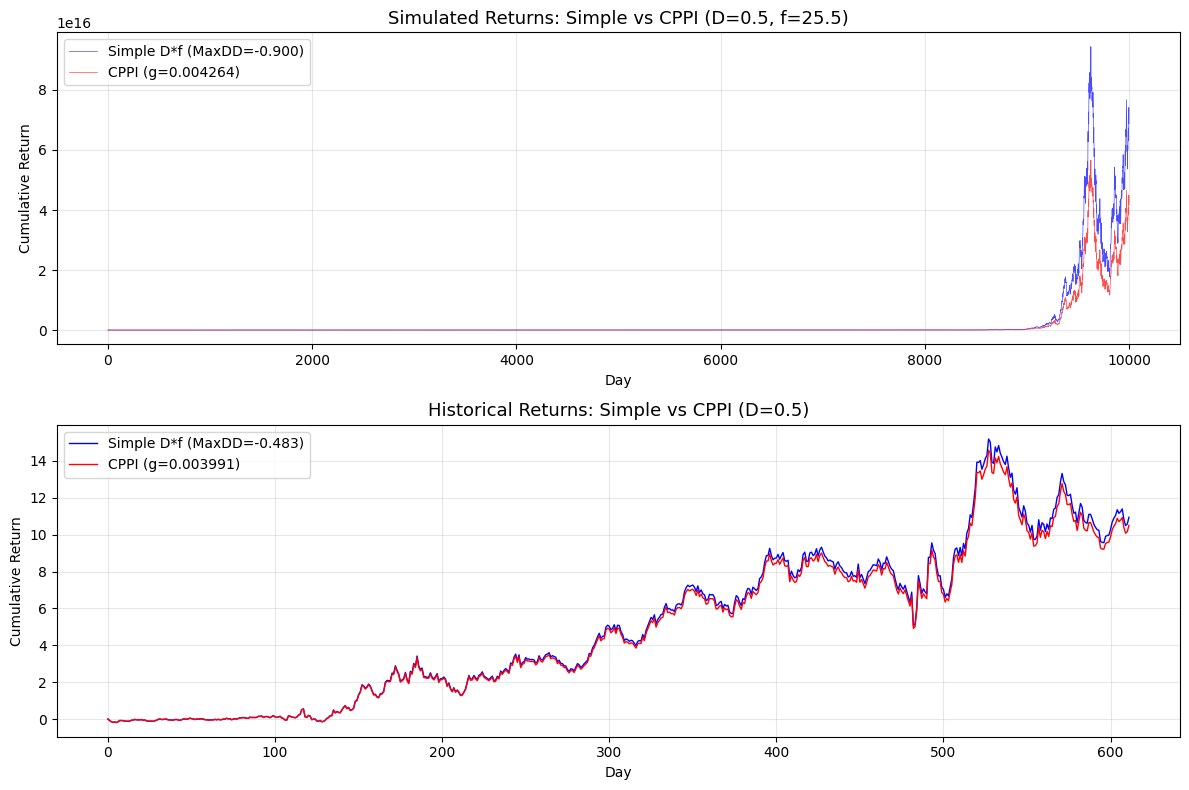

In [9]:
# 차트: CPPI vs 단순 레버리지 비교
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# 시뮬레이션 수익률 비교
simple_cumret_sim = np.cumprod(1 + optimalF * D * ret_sim) - 1
cppi_cumret_sim = np.exp(cppi_equity_sim) - 1

n_plot = min(10000, len(ret_sim))
axes[0].plot(range(n_plot), simple_cumret_sim[:n_plot], 'b-', linewidth=0.5,
             alpha=0.7, label=f'Simple D*f (MaxDD={maxDD_simple_sim:.3f})')
axes[0].plot(range(n_plot), cppi_cumret_sim[:n_plot], 'r-', linewidth=0.5,
             alpha=0.7, label=f'CPPI (g={g_cppi_sim:.6f})')
axes[0].set_title(f'Simulated Returns: Simple vs CPPI (D={D}, f={optimalF:.1f})', fontsize=13)
axes[0].set_ylabel('Cumulative Return')
axes[0].set_xlabel('Day')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 역사적 수익률 비교
simple_cumret_hist = np.cumprod(1 + optimalF * D * ret) - 1
cppi_cumret_hist = np.exp(cppi_equity_hist) - 1

axes[1].plot(range(len(ret)), simple_cumret_hist, 'b-', linewidth=1,
             label=f'Simple D*f (MaxDD={maxDD_simple_hist:.3f})')
axes[1].plot(range(len(ret)), cppi_cumret_hist, 'r-', linewidth=1,
             label=f'CPPI (g={g_cppi_hist:.6f})')
axes[1].set_title(f'Historical Returns: Simple vs CPPI (D={D})', fontsize=13)
axes[1].set_ylabel('Cumulative Return')
axes[1].set_xlabel('Day')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 7. 분석 5: 레버리지 민감도 분석

켈리 비율(0.05~1.0)에 따른 성장률과 최대 낙폭의 트레이드오프를 시각화한다.

In [10]:
# 분석 5: 레버리지 민감도 분석
print("=" * 60)
print("📈 분석 5: 레버리지 민감도 분석")
print("=" * 60)

fractions = np.arange(0.05, 1.05, 0.05)
growth_rates = []
max_drawdowns = []

for frac in fractions:
    lev = optimalF * frac
    gr = g_func(lev, ret_sim)
    cumret = np.cumprod(1 + lev * ret_sim) - 1
    maxDD, _, _ = calculateMaxDD(cumret)
    growth_rates.append(gr)
    max_drawdowns.append(maxDD)
    if frac in [0.1, 0.25, 0.5, 0.75, 1.0]:
        print(f"  f_frac={frac:.2f}, leverage={lev:.2f}: g={gr:.6f}, MaxDD={maxDD:.4f}")

📈 분석 5: 레버리지 민감도 분석
  f_frac=0.10, leverage=2.55: g=0.001093, MaxDD=-0.3196
  f_frac=0.25, leverage=6.38: g=0.002517, MaxDD=-0.6441
  f_frac=0.50, leverage=12.76: g=0.004317, MaxDD=-0.9003
  f_frac=1.00, leverage=25.51: g=0.005767, MaxDD=-0.9963


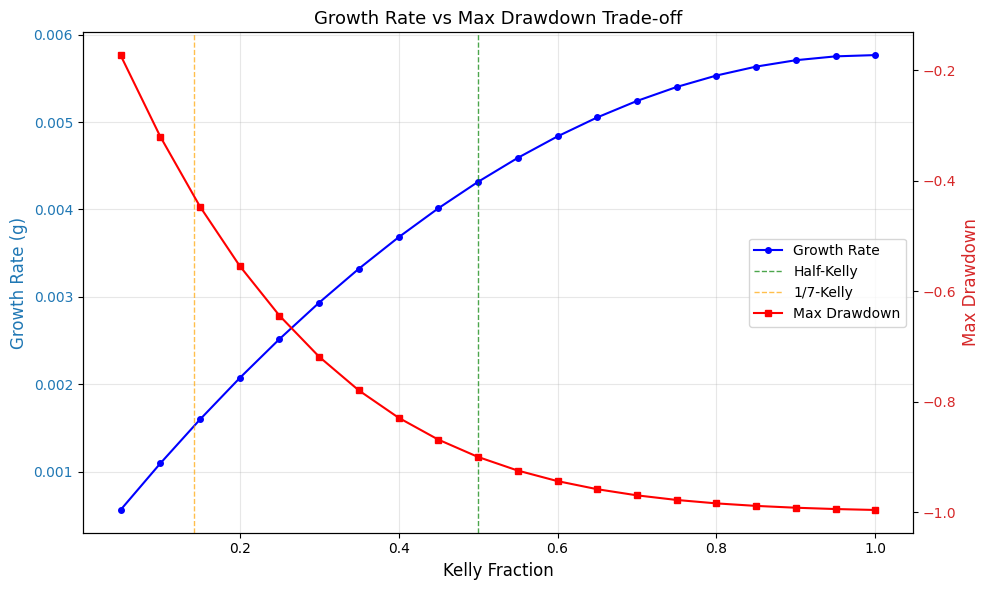

In [11]:
# 차트: 성장률 vs 최대 낙폭 트레이드오프
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Kelly Fraction', fontsize=12)
ax1.set_ylabel('Growth Rate (g)', color=color1, fontsize=12)
ax1.plot(fractions, growth_rates, 'b-o', markersize=4, linewidth=1.5, label='Growth Rate')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Max Drawdown', color=color2, fontsize=12)
ax2.plot(fractions, max_drawdowns, 'r-s', markersize=4, linewidth=1.5, label='Max Drawdown')
ax2.tick_params(axis='y', labelcolor=color2)

# 주요 지점 표시
ax1.axvline(x=0.5, color='green', linewidth=1, linestyle='--', alpha=0.7, label='Half-Kelly')
ax1.axvline(x=1.0/7, color='orange', linewidth=1, linestyle='--', alpha=0.7, label='1/7-Kelly')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=10)

plt.title('Growth Rate vs Max Drawdown Trade-off', fontsize=13)
plt.tight_layout()
plt.show()

---

## 8. 결론 및 권고사항

### 핵심 발견 요약

| 항목 | 결과 |
|------|------|
| 켈리 최적 레버리지 (가우시안) | 23.85 |
| 몬테카를로 최적 레버리지 | 25.51 |
| 파산 레버리지 한계 | 54.94 |
| 1/7 켈리 MaxDD | -0.4296 |
| CPPI 성장률 (D=0.5) | 0.004264 |

### 트레이딩 권고사항

1. **하프-켈리 이하 사용**: 켈리 최적 레버리지는 상한선으로만 사용. 추정 오류 시 과도한 레버리지 → 파산 위험.
2. **몬테카를로 검증**: 가우시안 가정의 한계를 극복하기 위해 팻 테일 분포(피어슨 시스템)로 시뮬레이션 검증.
3. **CPPI 활용**: 최대 낙폭 제약이 있는 경우 CPPI가 최선의 선택. 성장률 손실 미미하면서 낙폭 보장.
4. **손절매**: 평균 회귀 전략에는 백테스트 최대 낙폭 이상으로 설정. 모멘텀 전략에는 자연스러운 일부.
5. **리스크 지표**: VIX, TED 스프레드 등 선행 지표로 위험 기간 회피 가능.

### 주의사항

- 모든 최적화는 **미래 수익률 분포가 과거와 동일하다**는 가정에 의존
- 시뮬레이션 기반 MaxDD는 백만 년에 한 번 발생하는 극단적 시나리오일 수 있음
- 역사적 수익률 기반 분석은 최악의 시나리오를 포착하기에 데이터가 제한적
- 야간 갭이나 유동성 철회 시 손절매/CPPI도 보호 불가 → 옵션 매수 고려
- 일정 레버리지 유지 요구는 '손실 시 매도' → 금융 위기 시 전염 가능성